### Ontario Gateway: 5 years

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale

In [24]:
# Aircraft info: Boeing 757-200, Airbus A340-200, Airbus A340-300, respectively
num_aircraft = np.array([47, 15, 24])
num_flights_per_day = np.array([6, 2.25, 2])
replacement_cost = np.array([56400000, 78900000, 88500000], dtype=np.int64)
fleet_value = np.dot(num_aircraft, replacement_cost)

num_days_per_year = 342
accident_rate = 1 / 5000000

num_flights_per_year = np.ceil(num_aircraft * num_flights_per_day * num_days_per_year).astype(int)

In [25]:
N = 1000000
M = len(num_aircraft)

aircraft_losses = np.zeros((N, 5))
incidental_losses = np.zeros((N, 5))
total_losses = np.zeros((N, 5))

In [26]:
for i in range(5):
    dat_accident = np.zeros((N, M))
    for k in range(M):
        dat_accident[:, k] = np.random.binomial(num_flights_per_year[k], accident_rate, N)
    
    aircraft_losses[:, i] = np.sum(dat_accident * replacement_cost, axis=1)
    incidental_losses[:, i] = np.random.uniform(1000000, 5000000, N)

total_losses = aircraft_losses + incidental_losses

In [27]:
cost_RCNC1 = 0.0045 * fleet_value * 5 + 0.10 * np.sum(total_losses, axis=1) - 0.20 * np.maximum(0.0045 * fleet_value * 5 - 0.90 * np.sum(total_losses, axis=1), 0)
cost_RCNC2 = 0.001 * fleet_value * 5 + np.sum(np.minimum(0.90 * total_losses, 0.01 * fleet_value), axis=1)
cost_CTC = 13000000 * 5 + np.sum(0.10 * np.minimum(total_losses, 80000000), axis=1) + np.sum(np.maximum(total_losses - 80000000, 0), axis=1)
cost_HIC = (0.00165 * fleet_value * 5) + np.sum(np.minimum(total_losses, 24000000), axis=1) - (0.035 * ((0.00165 * fleet_value * 5) - np.sum(np.maximum((total_losses - 24000000), 0), axis=1)))
cost_SELF = np.sum(total_losses, axis=1)

In [28]:
policy_summary = pd.DataFrame(columns=["policy", "exp_cost", "sd_cost"])

policies = ["RCNC1", "RCNC2", "CTC", "HIC", "SELF"]
policy_summary["policy"] = policies
policy_summary["exp_cost"] = [np.mean(cost_RCNC1), np.mean(cost_RCNC2), np.mean(cost_CTC), np.mean(cost_HIC), np.mean(cost_SELF)]
policy_summary["sd_cost"] = [np.std(cost_RCNC1, ddof=1), np.std(cost_RCNC2, ddof=1), np.std(cost_CTC, ddof=1), np.std(cost_HIC, ddof=1), np.std(cost_SELF, ddof=1)]
policy_summary['exp_cost'] = policy_summary['exp_cost'].map(lambda x: f"${x:,.0f}")
policy_summary['sd_cost'] = policy_summary['sd_cost'].map(lambda x: f"${x:,.0f}")
print(policy_summary)

  policy      exp_cost      sd_cost
0  RCNC1  $113,633,273   $6,303,121
1  RCNC2   $49,721,897  $18,258,950
2    CTC   $67,537,751   $3,917,210
3    HIC   $65,205,808   $8,201,504
4   SELF   $22,828,986  $22,709,012


In [29]:
# Make data frame for histograms
dat = pd.DataFrame({
    "CTC": cost_CTC,
    "HIC": cost_HIC
})

In [30]:
# Set the locale for formatting numbers with thousands separators
locale.setlocale(locale.LC_ALL, '')

'English_United States.1252'

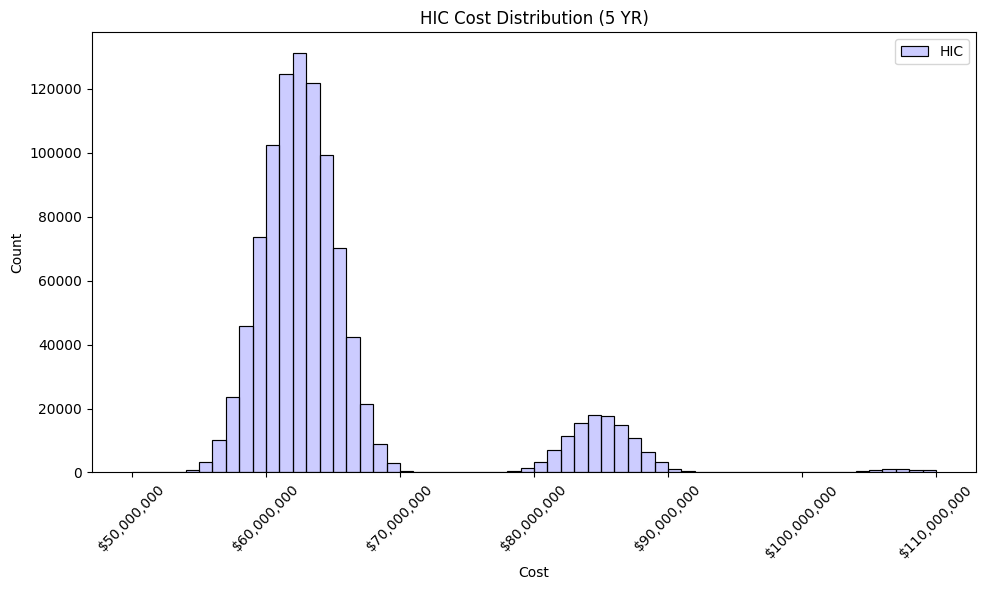

In [31]:
# Make a histogram for HIC
plt.figure(figsize=(10, 6))
bins_hic = np.arange(50000000, 110000001, 1000000)
sns.histplot(data=dat, x="HIC", bins=bins_hic, color="blue", alpha=0.2, label="HIC")
plt.title("HIC Cost Distribution (5 YR)")
plt.xlabel("Cost")
plt.ylabel("Count")

# Format x-axis labels as dollars
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "${:,.0f}".format(x)))

plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
p1 = plt.gca()
plt.show()

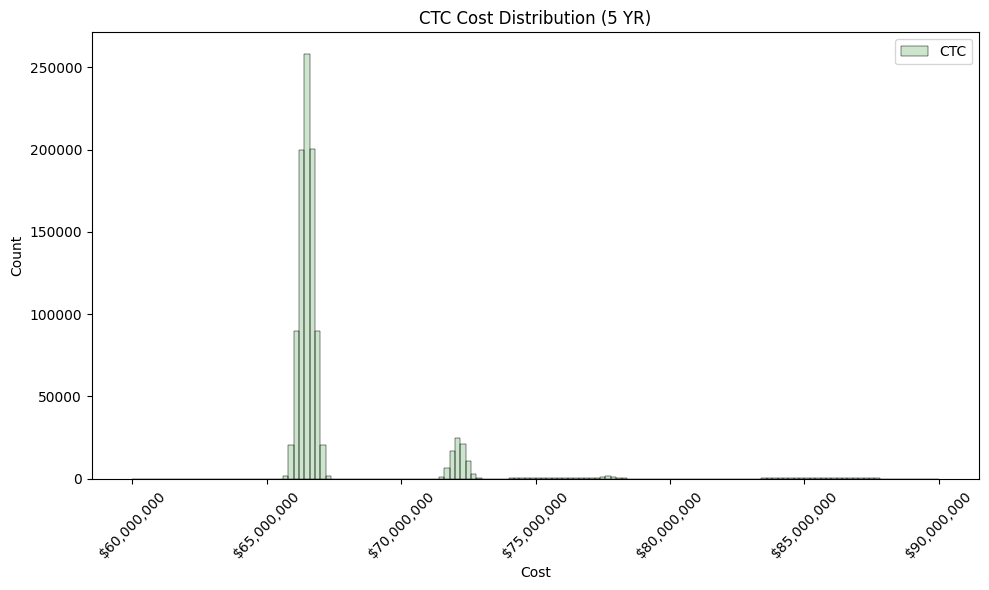

In [32]:
# Make a histogram for CTC
plt.figure(figsize=(10, 6))
bins_ctc = np.arange(60000000, 90000001, 200000)
sns.histplot(data=dat, x="CTC", bins=bins_ctc, color="green", alpha=0.2, label="CTC")
plt.title("CTC Cost Distribution (5 YR)")
plt.xlabel("Cost")
plt.ylabel("Count")

# Format x-axis labels as dollars
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "${:,.0f}".format(x)))

plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
p2 = plt.gca()
plt.show()

C:\Users\taugust\AppData\Local\Temp\ipykernel_94348\2918665677.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


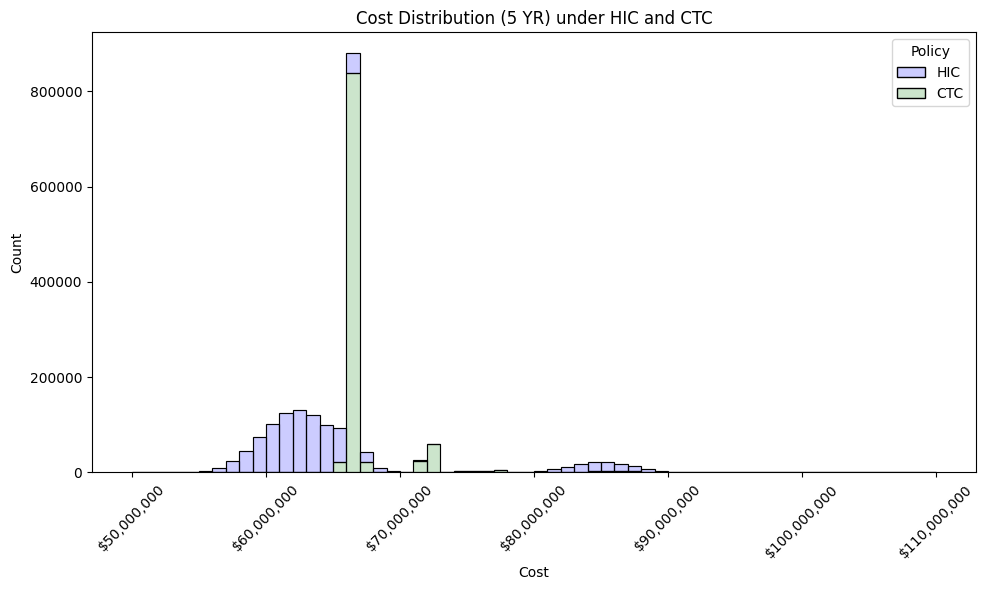

In [33]:
# Create overlayed combine plots
stacked_data = pd.melt(dat[["HIC", "CTC"]], var_name="policy", value_name="cost")

plt.figure(figsize=(10, 6))
bins_comb = np.arange(50000000, 110000001, 1000000)
palette_comb = {"HIC": "blue", "CTC": "green"}
sns.histplot(data=stacked_data, x="cost", bins=bins_comb, hue="policy", hue_order=['HIC', 'CTC'], palette=palette_comb, multiple="stack", alpha=0.2)
# sns.histplot(data=stacked_data, x="cost", bins=bins_comb, hue="policy", palette=palette_comb, multiple="stack", alpha=0.2,
#              element="step", stat="density", common_norm=False, label="policy")
plt.title("Cost Distribution (5 YR) under HIC and CTC")
plt.xlabel("Cost")
plt.ylabel("Count")

# Format x-axis labels as dollars
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "${:,.0f}".format(x)))

plt.xticks(rotation=45)
plt.tight_layout()

p3 = plt.gca()
legend = p3.get_legend()
handles = legend.legendHandles
legend.remove()
plt.legend(handles, ['HIC', 'CTC'], title='Policy')
# plt.legend()
#plt.legend(['CTC', 'HIC'])
plt.show()

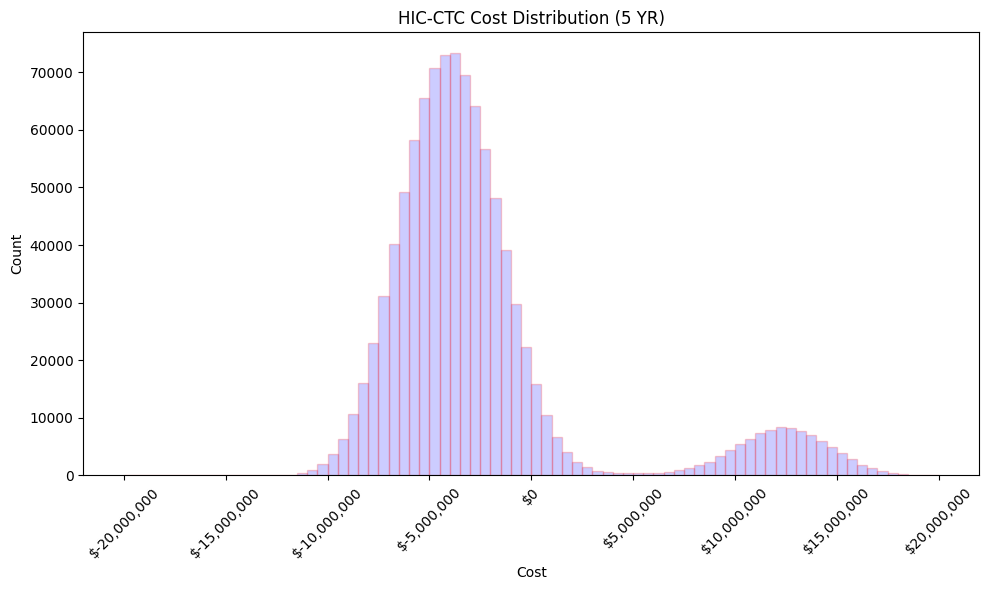

In [34]:
# Subtract policies
dat["HIC_minus_CTC"] = dat["HIC"] - dat["CTC"]
plt.figure(figsize=(10, 6))
bins_sub = np.arange(-20000000, 20000001, 500000)
plt.hist(dat["HIC_minus_CTC"], bins=bins_sub, color="blue", alpha=0.2, edgecolor="red")
plt.title("HIC-CTC Cost Distribution (5 YR)")
plt.xlabel("Cost")
plt.ylabel("Count")

# Format x-axis labels as dollars
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "${:,.0f}".format(x)))

plt.xticks(rotation=45)
plt.tight_layout()
p4 = plt.gca()
plt.show()

In [35]:
# Get quantiles
quantiles = pd.DataFrame({
    "Quantiles": dat["HIC_minus_CTC"].quantile(np.arange(0, 1.05, 0.05))
})
quantiles

,Quantiles
0.00,-1.061039e+08
0.05,-7.801106e+06
0.10,-6.943246e+06
0.15,-6.350564e+06
0.20,-5.866604e+06
0.25,-5.447740e+06
0.30,-5.065448e+06
0.35,-4.706093e+06
0.40,-4.361096e+06
0.45,-4.020198e+06


In [36]:
print("Mean:", dat["HIC_minus_CTC"].mean())
print("Standard Deviation:", dat["HIC_minus_CTC"].std())

Mean: -2331943.6635286696
Standard Deviation: 5915243.128354926
